# 1/29/21 - This notebook selects and prepares a first LinKS candidate for modeling.

In [258]:
### libraries
%matplotlib inline
import matplotlib.pyplot as plt
from autoconf import conf
import autolens as al
import autolens.plot as aplt
import autofit as af
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.stats import sigma_clip as clip

from pyprojroot import here

workspace_path = '/data/sknabel/autolens_workspace'
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")
# paths
autoz_path = '/data/sknabel/autoz_lens_model/'
file_path = f'{autoz_path}files/'
csv_path = f'{file_path}csv/'
fits_path = f'{file_path}fits/'
png_path = f'{autoz_path}visuals/png/'
pdf_path = f'{autoz_path}visuals/pdf/'

/data/sknabel/autolens_workspace
Working Directory has been set to `/data/sknabel/autolens_workspace`


In [259]:
# load links
links = pd.read_csv(f'{csv_path}latest/links_sample_latest.csv')
print(len(links), links.columns)

39 Index(['Unnamed: 0', 'Unnamed: 0_x', 'GAMA_ID', 'ID', 'RA', 'DEC', 'score',
       'Unnamed: 0_y', 'z1', 'sigma1', 'template1', 'z2', 'sigma2',
       'template2', 'sigma3', 'sigma4', 'R', 'prob', 'error', 'type',
       'type_number', 'lambdar_log_mstar', 'lambdar_mstar',
       'lambdar_log_mstar_error', 'z', 'zlens', 'zsource', 'sigma_lens',
       'sigma_source', 'dlens', 'dsource', 'corrected_stellar_mass', 'P1',
       'P3', 'normalized_score', 'cnn_probability', 'm_half_re', 'sigma_star',
       'theta_e_pm', 'theta_e_sis'],
      dtype='object')


In [260]:
links.sort_values(by='score', ascending=False).head()[['GAMA_ID',
                                                      'ID',
                                                      'score',
                                                      'zlens',
                                                      'zsource',
                                                      'corrected_stellar_mass',
                                                      'theta_e_pm',
                                                     'theta_e_sis']]

,GAMA_ID,ID,score,zlens,zsource,corrected_stellar_mass,theta_e_pm,theta_e_sis
18,323152.0,2967,30.0,0.353286,0.721590,NaN,NaN,NaN
17,250289.0,2730,28.0,0.401214,0.719616,4.664644e+11,0.917868,0.645859
19,3575500.0,1906,26.0,0.232537,0.365195,3.049251e+11,1.296096,0.762649
31,3629152.0,1933,26.0,0.406623,0.787118,4.270558e+11,0.896116,0.659574
11,544226.0,3212,18.0,0.227044,0.649824,1.928528e+11,0.875230,0.725515


## I am selecting G3575500 (1906) with score of	26, redshifts 0.232537 and 0.365195, mass 3.049251e+11, and $\theta_E$	1.296096 and 0.762649

Filename: /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (101, 101)   float32   
None


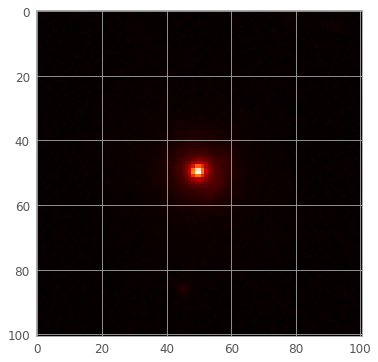

In [261]:
# Let's look at r-band image
folder = f'{fits_path}G3575500_1906/'
file = '1906_r.fits'

# get the file ready
hdul = fits.open(f'{folder}{file}') # open the fits
print(hdul.info())
image = hdul[0].data # select first HDU to be the image
    
# plot image data
plt.figure()
plt.title = (f'{hdul[0].header[6]}')
plt.imshow(image)#, cmap='gray') # show image in grayscale
plt.show()


In [262]:
# resize to zoom in
#image.shape=(101,101)

def reshape_image(image):
    print('Resizing image to half size.')
    size=image.shape[0]
    new_size=int(np.around(size/2)) # since it's indexed starting at 0, 50 will be the central 51st pixel
    lower = int(new_size/2)
    upper = 3*int(new_size/2)
    resized_image=image[lower:upper,lower:upper]
    return(resized_image)

In [263]:
# reshape and save resized image
def reshape_image_from_file(folder, file):
    # get the file ready
    hdul = fits.open(f'{folder}{file}') # open the fits
    print(f'Gettin noisey with {hdul[0].header[6]}') # list object name
    print(hdul.info())
    image = hdul[0].data # select first HDU to be the image
    
    # plot image data
    plt.figure()
    plt.title = (f'{hdul[0].header[6]}')
    plt.imshow(image)#, cmap='gray') # show image in grayscale
    plt.show()
    
    image_resized=reshape_image(image)
    
    # plot resized image data
    plt.figure()
    plt.title = (f'{hdul[0].header[6]}')
    plt.imshow(image_resized)#, cmap='gray') # show image in grayscale
    plt.show()

    # write to fits file
    hdu = fits.PrimaryHDU(image_resized)
    hdu.writeto(f'{folder}{file[:-5]}_image_resized.fits', overwrite=True)
    print(f'Image sent to {folder}{file[:-5]}_image_resized.fits')
    # good vibes
    print('Hooray!')

Gettin noisey with KIDS_129.0_-1.5
Filename: /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (101, 101)   float32   
None


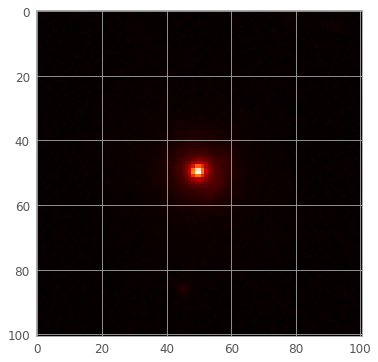

Resizing image to half size.


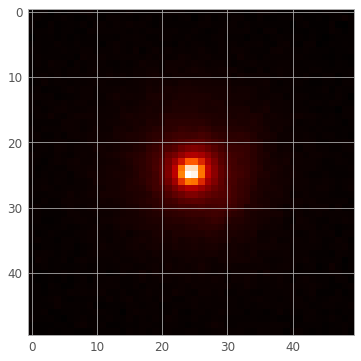

Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r_image_resized.fits
Hooray!


In [264]:
reshape_image_from_file(folder, file)

In [265]:
def get_noisey_from_file(folder, file): # insert fits file path (f'{fits_image_path}links/G262874_26/G262874_26_r.fits')
    
    # get the file ready
    hdul = fits.open(f'{folder}{file}') # open the fits
    print(f'Gettin noisey with {hdul[0].header[6]}') # list object name
    print(hdul.info())
    image = hdul[0].data # select first HDU to be the image
    
    # plot image data
    plt.figure()
    plt.title = (f'{hdul[0].header[6]}')
    plt.imshow(image)#, cmap='gray') # show image in grayscale
    plt.show()
    #
    plt.figure()
    plt.title = (f'{hdul[0].header[6]} signal')
    plt.hist(np.ravel(image),bins=100,log=True) # plot signal in histogram
    plt.show()
    print(f'Mean {np.mean(image)}, Median {np.median(image)}')
    
    # clip to 3sigma around median
    print('Clipping to 3-sigma about median value')
    clipped_image=clip(image, cenfunc='median')
    plt.figure()
    plt.title=(f'{hdul[0].header[6]} noise')
    plt.hist(np.ravel(clipped_image),bins=100,log=True) # plot signal in histogram
    plt.show()
    
    # generate Gaussian noise about mean and std
    mean = clipped_image.mean()
    std = clipped_image.std()
    noise_map = np.random.normal(loc=mean,
                                scale=std,
                                size= image.shape
                                )
    
    # plot noise map
    plt.figure() # show histogram of signal values
    plt.hist(np.ravel(noise_map))
    plt.show()
    plt.figure() # show noise map image
    plt.title=(f'Noise Map for {hdul[0].header[6]}')
    plt.imshow(noise_map, cmap='gray')
    
    # write to fits file
    hdu = fits.PrimaryHDU(noise_map)
    hdu.writeto(f'{folder}{file[:-5]}_noisemap.fits', overwrite=True)
    print(f'Image sent to {folder}{file[:-5]}_noisemap.fits')
    
    # resize noise map
    noise_map_resized = reshape_image(noise_map)
    print(f'New noise_map shape: {noise_map_resized.shape}')
    plt.figure() # show noise map image
    plt.title=(f'Noise Map for {hdul[0].header[6]}')
    plt.imshow(noise_map_resized, cmap='gray')
    
    # write to fits file
    hdu = fits.PrimaryHDU(noise_map_resized)
    hdu.writeto(f'{folder}{file[:-5]}_noisemap_resized.fits', overwrite=True)
    print(f'Image sent to {folder}{file[:-5]}_noisemap_resized.fits')
    # good vibes
    print('Congratulations! You simulated random noise! Eat a cookie.')
    
    
#get_noisey(f'{fits_image_path}links/G262874_26/G262874_26_r.fits') # it works!

Gettin noisey with KIDS_129.0_-1.5
Filename: /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (101, 101)   float32   
None


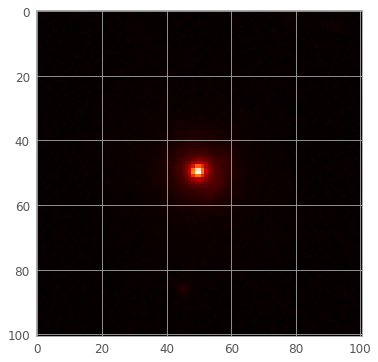

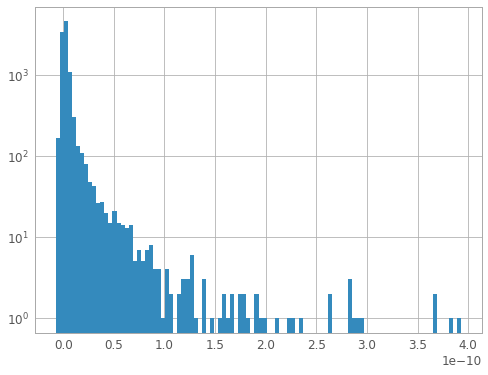

Mean 4.476720643492582e-12, Median 1.5364653993543698e-12
Clipping to 3-sigma about median value


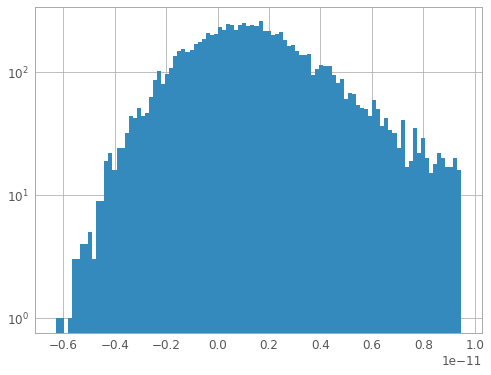

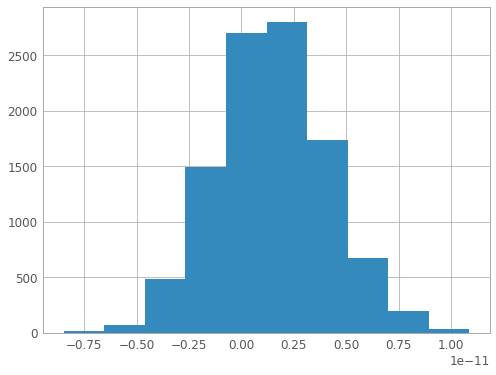

Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r_noisemap.fits
Resizing image to half size.
New noise_map shape: (50, 50)
Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r_noisemap_resized.fits
Congratulations! You simulated random noise! Eat a cookie.


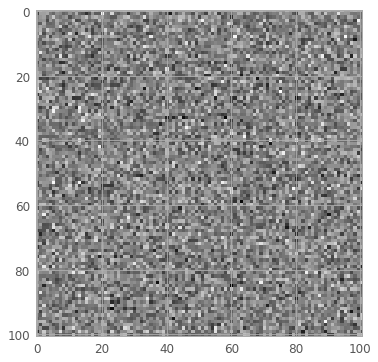

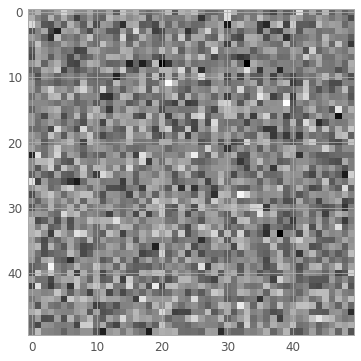

In [266]:
folder = f'{fits_path}G3575500_1906/'
file = '1906_r.fits'

get_noisey_from_file(folder, file)

## Need to determine pixel scale. I don't believe I've been able to find it in the data from the fits file. Maybe I'm just not looking closely enough.
## Petrillo-18 says it's 101x101 pixels (20x20 arcsec)
## I take that to mean that the pixel scale is 20/101 or 0.198 arcsec per pixel.
## Average PSF is 0.65... How many pixels is that? that's 2$\sigma$ of the Gaussian? Divide by 2? That gives us sigma_psf?

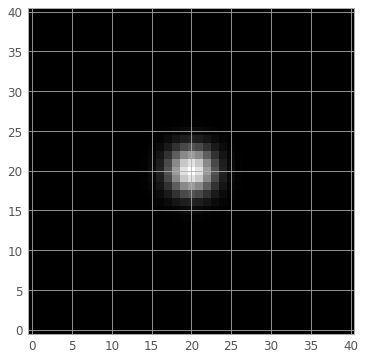

In [267]:
# from astropy tutorial
size = 20  # on each side from the center
sigma_psf = 2.0
y, x = np.mgrid[-size:size+1, -size:size+1]
psf = np.exp(-(x**2 + y**2)/(2.0*sigma_psf**2))
psf /= np.sum(psf)
plt.imshow(psf, origin='lower', cmap='gray')

In [268]:
avg_psf = 0.65 # arcsec
avg_psf_pxl = 0.65/0.198 # pixels
sigma_psf = avg_psf_pxl/2 # = 1.64
sigma_psf

1.6414141414141414

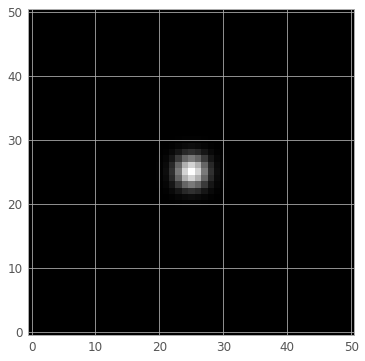

In [269]:
# let's try to make this work...
size = 25 # gives a grid of 51 (25 on either side of the center)
y, x = np.mgrid[-size:size+1, -size:size+1]
psf = np.exp(-(x**2 + y**2)/(2.0*sigma_psf**2))
psf /= np.sum(psf)
plt.imshow(psf, origin='lower', cmap='gray')

In [270]:
# write a function for psf determination (r band is 0.65 arcsec and 0.198 pixelscale)
def point_to_the_spread(folder, file, psf, pixel_scale):
    # get the file ready
    hdul = fits.open(f'{folder}{file}') # open the fits
    print(f'Point the way to {hdul[0].header[6]}!') # list object name
    print(hdul.info())
    image = hdul[0].data # select first HDU to be the image
    
    # plot image data
    plt.figure()
    plt.title = (f'{hdul[0].header[6]}')
    plt.imshow(image)#, cmap='gray') # show image in grayscale
    plt.show()
    
    # define psf values
    avg_psf = psf # arcsec
    avg_psf_pxl = avg_psf/pixel_scale # pixels
    sigma_psf = avg_psf_pxl/2 # = 1.64
    size = int(np.around(image.shape[0]/2)) # gives a grid of 101 (50 on either side of the center)
    
    # set psf for 101, 101 image
    y, x = np.mgrid[-size:size+1, -size:size+1]
    psf = np.exp(-(x**2 + y**2)/(2.0*sigma_psf**2))
    psf /= np.sum(psf)
    plt.imshow(psf, origin='lower', cmap='gray')
    
    # write to fits file
    hdu = fits.PrimaryHDU(psf)
    hdu.writeto(f'{folder}{file[:-5]}_psf.fits', overwrite=True)
    print(f'Image sent to {folder}{file[:-5]}_psf.fits')
    
    # resize psf
    psf_resized = reshape_image(psf)
    print(f'New noise_map shape: {psf_resized.shape}')
    plt.figure() # show psf image
    plt.title=(f'psf for {hdul[0].header[6]}')
    plt.imshow(psf_resized, cmap='gray')
    
    # write to fits file
    hdu = fits.PrimaryHDU(psf_resized)
    hdu.writeto(f'{folder}{file[:-5]}_psf_resized.fits', overwrite=True)
    print(f'Image sent to {folder}{file[:-5]}_psf_resized.fits')
    # good vibes
    print('This has been fun, right? Very fun! :)')

Point the way to KIDS_129.0_-1.5!
Filename: /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (101, 101)   float32   
None


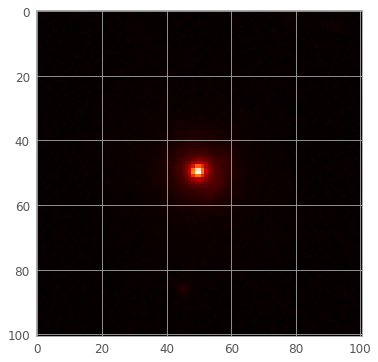

Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r_psf.fits
Resizing image to half size.
New noise_map shape: (50, 50)
Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r_psf_resized.fits
This has been fun, right? Very fun! :)


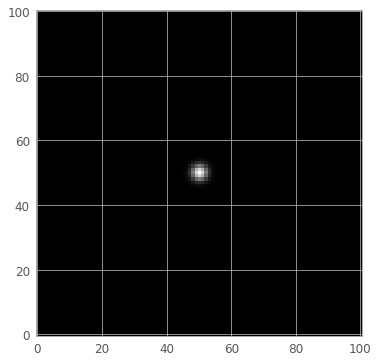

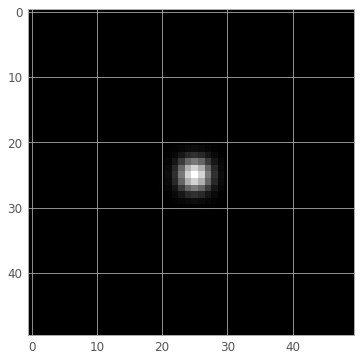

In [271]:
point_to_the_spread(folder, file, psf=0.65, pixel_scale=0.198)

## Woo! I think I got it :)

TypeError: 'str' object is not callable

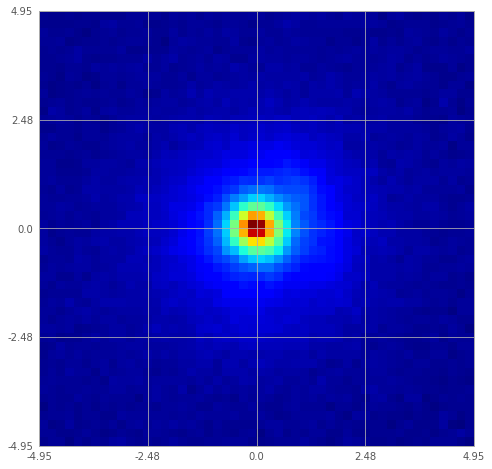

In [272]:
# Now we pull in the imaging\
from os import path

imaging = al.Imaging.from_fits(image_path=path.join(folder, '1906_r_image_resized.fits'),
                              noise_map_path=path.join(folder, '1906_r_noisemap_resized.fits'),
                              psf_path=path.join(folder, '1906_r_psf_resized.fits'),
                               pixel_scales=0.198)
mask = al.Mask2D.circular(
    shape_2d=imaging.shape_2d, pixel_scales=imaging.pixel_scales, sub_size=1, radius=3.0
)
visuals_2d = aplt.Visuals2D(mask=mask)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot(image=True,psf=True)